# Model 2: A graph-based model of segment borrowability

This report includes supplementary materials for:

    Operationalizing borrowability: A case study from phonological segments

In [1]:
import networkx as nx
import re

import pandas as pd
import numpy as np

from vincenty import vincenty
from scipy.spatial import Delaunay

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.img_tiles import Stamen

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

In [3]:
def load_cldf_dataset(path_to_values, path_to_languages):
    values = pd.read_csv(path_to_values)
    languages = pd.read_csv(path_to_languages)
    return pd.merge(left = values, right = languages, how="left",
                    left_on="Language_ID", right_on="ID")

In [4]:
from collections import Counter

def get_frequencies_w_inventory_collapsing(dataset):
    glottocode_to_inventory = defaultdict(set)
    for row in dataset.itertuples():
        if not pd.isnull(row.Language_ID):
            glottocode_to_inventory[row.Language_ID].add(row.Value)
    print(f'{len(glottocode_to_inventory)} languages')
    frequencies_absolute = Counter()
    for segments in glottocode_to_inventory.values():
        for segment in segments:
            frequencies_absolute[segment] += 1
    frequencies_relative = {
        segment: count / len(glottocode_to_inventory)
        for segment, count in frequencies_absolute.items()
    }
    return frequencies_absolute, frequencies_relative

In [5]:
segbo = load_cldf_dataset('../data/segbo/cldf/values.csv',
                          '../data/segbo/cldf/languages.csv')
phoible = load_cldf_dataset('../data/phoible/cldf/values.csv',
                            '../data/phoible/cldf/languages.csv')

In [6]:
phoible_languages = pd.read_csv('../data/phoible/cldf/languages.csv')

# Filter out languages without glottocodes and coordinates
not_na = lambda x: not pd.isna(x)
phoible_languages = phoible_languages.loc[
    phoible_languages['Glottocode'].map(not_na) &
    phoible_languages['Latitude'].map(not_na) &
    phoible_languages['Longitude'].map(not_na)
]
phoible_languages.index = phoible_languages['Glottocode']

phoible_languages_filtered = set(phoible_languages.Glottocode)
phoible = phoible.loc[ phoible.Glottocode.map(lambda gltc: gltc in phoible_languages_filtered) ]

In [7]:
phoible_langs = set(phoible.Language_ID)
segbo = segbo.loc[ segbo.Language_ID.map(lambda gltc: gltc in phoible_langs) ]

## Construct the graph

In [8]:
# http://earthpy.org/tag/scipy.html
def lat_lon_to_cartesian(lat, lon, R = 1):
    """
    calculates lon, lat coordinates of a point on a sphere with
    radius R
    """
    lon_r = np.radians(lon)
    lat_r = np.radians(lat)

    x = R * np.cos(lat_r) * np.cos(lon_r)
    y = R * np.cos(lat_r) * np.sin(lon_r)
    z = R * np.sin(lat_r)
    return (x,y,z)

In [9]:
def plot_graph(G_loc, coords_dict, figsize=(16,10)):
    # Create points
    lats = []
    lons = []
    for lang, coords_tuple in coords_dict.items():
        if lang in G_loc.nodes():
            lat, lon = coords_tuple
            lats.append(lat)
            lons.append(lon)

    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    plt.plot(lons, lats, marker='o', color='red', markersize=2,
              transform=ccrs.PlateCarree(), linewidth=0)
    
    # Create a line collection from the graph
    rev_t = lambda tpl: (tpl[1], tpl[0])
    lines = [[] for i in range(len(G_loc.edges()))]
    for i, edge in enumerate(G_loc.edges()):
        t, h = edge
        lines[i] = [
            rev_t(coords_dict[t]),
            rev_t(coords_dict[h])
        ]
    lc = LineCollection(lines, colors='brown', linewidths=0.5)
    _ = ax.add_collection(lc)

In [10]:
coords_dict = {}
for row in phoible_languages.itertuples():
    coords_dict[row.Glottocode] = (row.Latitude, row.Longitude)

cartesian_coords_dict = {
    k: lat_lon_to_cartesian(*v) for k, v in coords_dict.items()
}

name_arr = sorted(coords_dict)
name_dict = {
    name: i for i, name in enumerate(name_arr)
}
points_arr = [cartesian_coords_dict[lang] for lang in name_arr]

In [11]:
tri = Delaunay(points_arr)
indptr, indices = tri.vertex_neighbor_vertices

In [12]:
G = nx.Graph()
for k in range(len(indptr)-1):
    point_gltc = name_arr[k]
    G.add_node(point_gltc)
    neighbours = indices[indptr[k]:indptr[k+1]]
    for n in neighbours:
        neigh_gltc = name_arr[n]
        if vincenty(
            coords_dict[point_gltc],
            coords_dict[neigh_gltc]
        ) <= 500:
            G.add_edge(point_gltc, neigh_gltc)

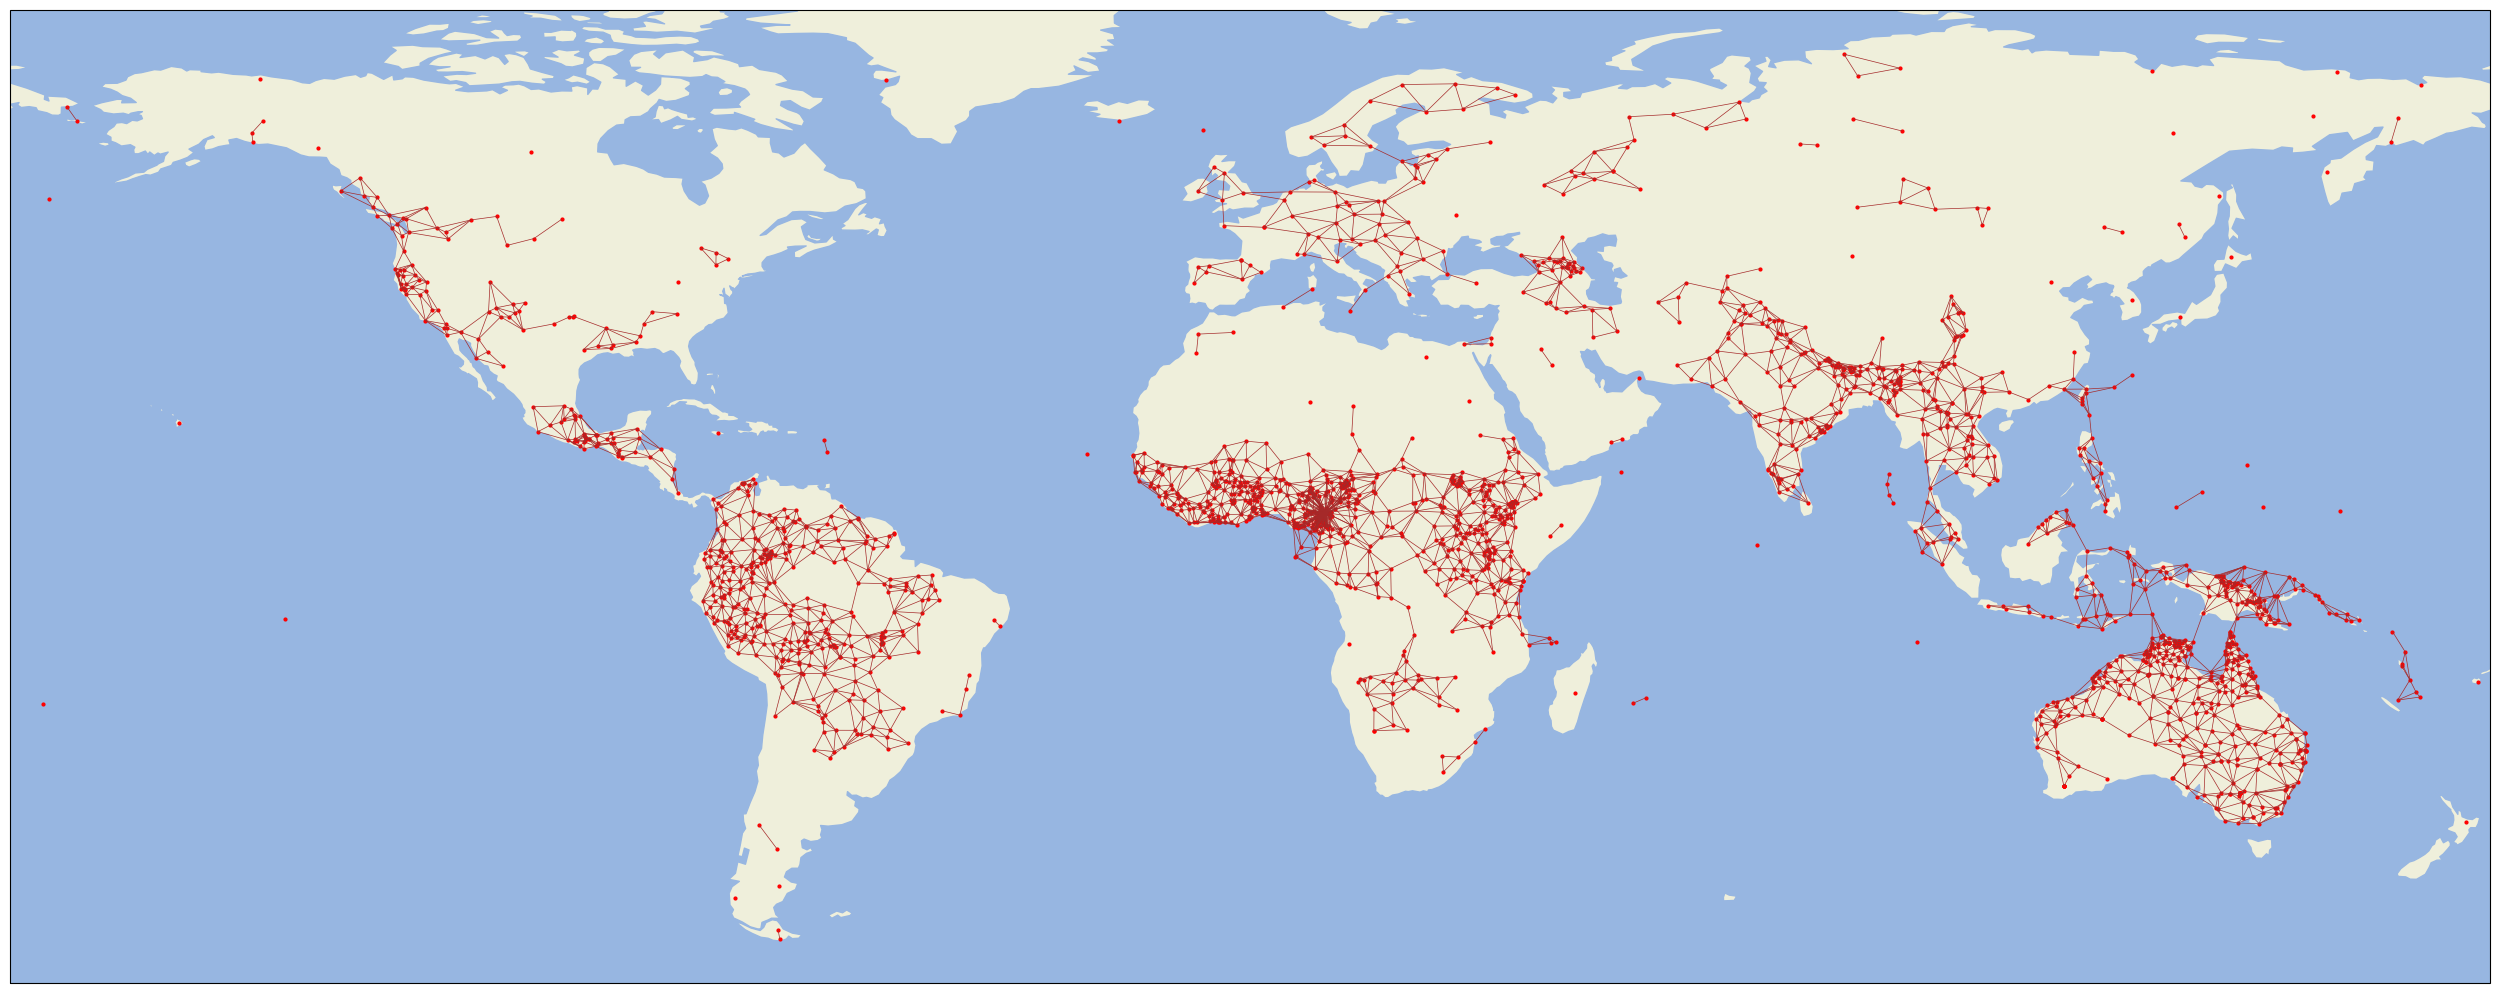

In [13]:
plot_graph(G, coords_dict, (32,20))

In [14]:
# Enrich the graph with new edges:
# connect with major languages all languages
# that borrowed segments from them together
# with their neighbours.
colonial = ['stan1288', 'stan1293', 'arab1395',
            'indo1316', 'russ1263', 'macr1272',
            'stan1290', 'dutc1256']

In [15]:
# The enrichment loop
for row in segbo.itertuples():
    gltc = row.Glottocode
    if gltc not in G.nodes():
        continue
    slgltcs_str = row.Source_Language_ID
    if pd.isna(slgltcs_str) or \
    slgltcs_str == 'unknown' or \
    slgltcs_str == '':
        continue
    slgltcs = re.split(r',\s*', slgltcs_str)
    for slgltc in slgltcs:
        if slgltc not in G.nodes():
            continue
        G.add_edge(gltc, slgltc)
        # For languages borrowing from colonial languages,
        # also connect their neighbours to the donour.
        if slgltc in colonial:
            try:
                for ngltc in G.neighbors(gltc):
                    G.add_edge(ngltc, slgltc)
            except KeyError:
                continue

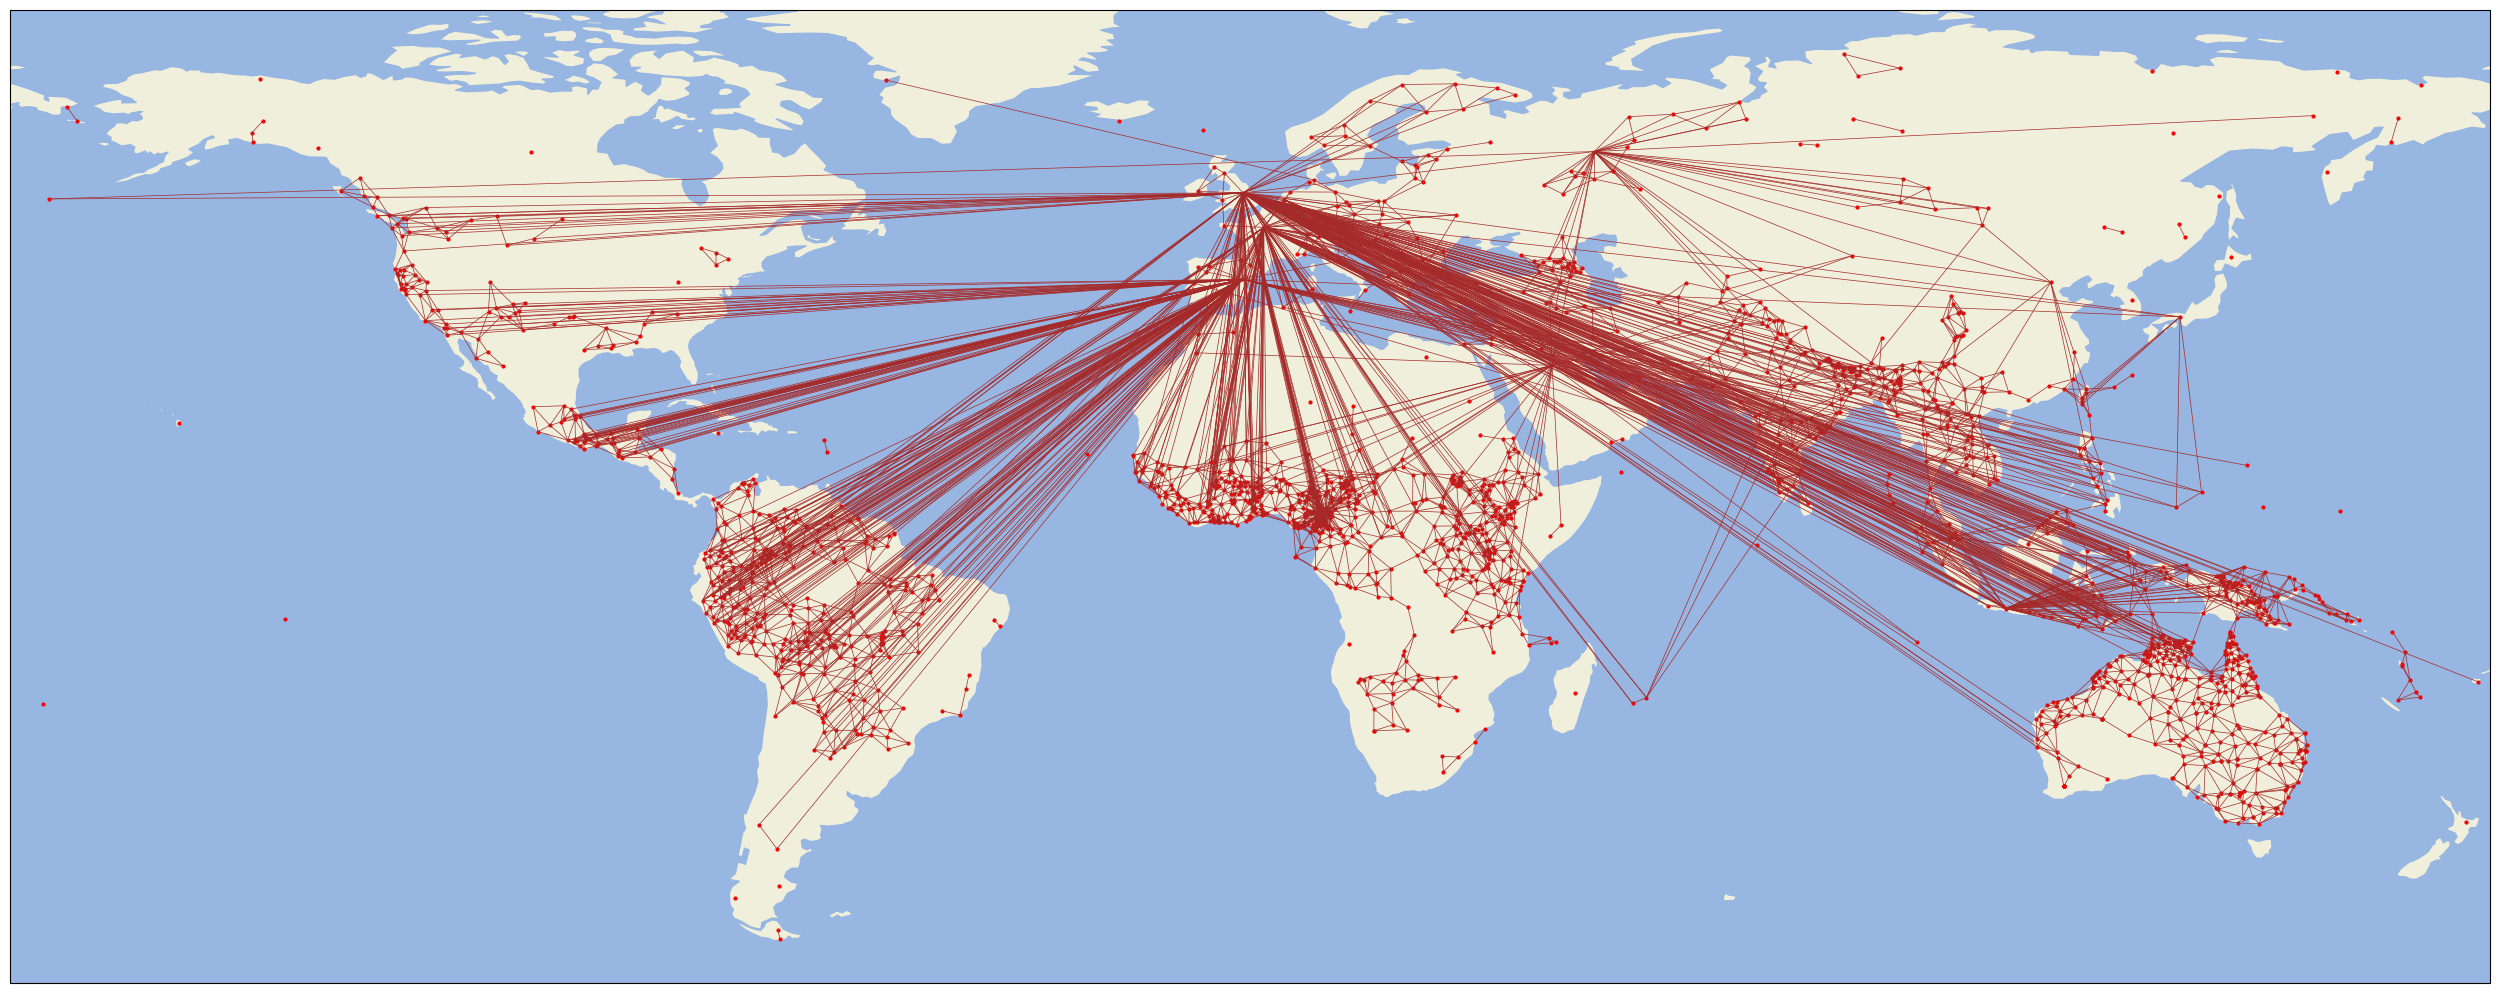

In [16]:
plot_graph(G, coords_dict, (32,20))

### The inference loop

For each language in the test set (langs without the segment in Phoible + langs that borrowed the segment), iterate over neighbours, look for contexts of exposure, count resulting borrowings.

In [17]:
def report_borrowability(segment_, segbo_, phoible_, inventories_, borrowing_langs_, all_langs_, G_):
    '''
    Returns a tuple consisting of
    (test-set size, # exposed langs, # borrowing events, borrowability)
    '''
    if segment_ not in borrowing_langs_:
        raise IndexError(f'{segment_} is missing from the dataset.')
    # The test set consists of
    # (1) languages that don't have the segment
    no_seg = set(all_langs_) - set(
        phoible_.loc[phoible_.Value == segment_].Glottocode)
    # (2) languages that borrowed the segment
    test_set = no_seg.union(
        set(segbo_.loc[segbo_.Value == segment].Glottocode))
    test_set = set([el for el in test_set if G_.has_node(el)])
    
    exposure_count = 0
    borrowing_count = 0
    for gltc in test_set:
        for n in G_.neighbors(gltc):
            # We exclude languages that eventually borrowed the segment.
            if n in test_set:
                continue
            if segment_ in inventories_[n]:
                exposure_count += 1
                if gltc in borrowing_langs_[segment]:
                    borrowing_count += 1
                break
    return (
        len(test_set), 
        exposure_count, 
        borrowing_count, 
        borrowing_count/exposure_count if exposure_count != 0 else 'NA'
    )

In [18]:
all_langs = phoible.Glottocode.unique()
len(all_langs)

2174

In [19]:
# Put langs' inventories into sets for quick access
from collections import defaultdict

inventories = defaultdict(set)
for i, row in phoible.iterrows():
    inventories[row.Glottocode].add(row.Value)

In [20]:
# Put langs that borrowed particular segments into sets
borrowing_langs = defaultdict(set)
for segment in segbo.Value.unique():
    for gltc in segbo.loc[
        segbo.Value == segment
    ].Glottocode.unique():
        borrowing_langs[segment].add(gltc)

In [21]:
with open('borrowability_on_the_graph.csv', 'w', encoding='utf-8') as out:
    out.write('Phoneme,TestSetSize,ExpCount,BorrowingCount,Borrowability\n')
    for segment in borrowing_langs:
        out.write(
            segment + 
            ',' + 
            ','.join(str(el) for el in report_borrowability(
                segment, segbo, phoible, inventories, borrowing_langs, all_langs, G
            )) + 
            '\n')

## Compare the results of the graph-based model with those given by Model 1

In this calculation, we collapsed all SegBo and PHOIBLE inventories together when checking if the segment is present or has been borrowed, so we will compare the results with "collapsed" scores from Model 1.

In [22]:
borrowability_dict = defaultdict(list)
for segment in borrowing_langs:
    _, _, _, b = report_borrowability(segment, segbo, phoible, inventories, borrowing_langs, all_langs, G)
    if b == 'NA':
        continue
    borrowability_dict['Segment'].append(segment)
    borrowability_dict['Borrowability'].append(b)

In [23]:
model2 = pd.DataFrame(borrowability_dict)

In [24]:
model1 = pd.read_csv('../probablistic_model/model_1_borrowability_laplace.csv')

In [25]:
# Exclude rare segments
(
    segbo_frequencies_absolute,
    _
) = get_frequencies_w_inventory_collapsing(segbo)

model1 = model1.loc[
    model1.Segment.map(lambda x: segbo_frequencies_absolute.get(x, 0) >= 10)]
model2 = model2.loc[
    model2.Segment.map(lambda x: segbo_frequencies_absolute.get(x, 0) >= 10)]

299 languages


In [26]:
# First we need to convert real-valued scores to ranks
# because they are not comparable across models.
model1 = model1[['Segment', 'Borrowability']]
model1['Rank'] = model1.Borrowability.rank(ascending=False)
model2['Rank'] = model2.Borrowability.rank(ascending=False)

In [27]:
model1.loc[model1.Segment == 'ʔ']

,Segment,Borrowability,Rank
123,ʔ,0.003221,23.0


In [28]:
model1.loc[ model1.Rank <= 10 ]

,Segment,Borrowability,Rank
27,f,0.031307,1.0
35,p,0.021112,2.0
43,ɡ,0.016310,3.0
48,b,0.013569,4.0
49,z,0.013512,5.0
50,ʒ,0.013032,6.0
56,d̠ʒ,0.011793,7.0
57,v,0.011674,8.0
58,d,0.011638,9.0
63,x,0.010977,10.0


In [29]:
both_models = pd.concat([model1, model2])
both_models['Model'] = [0] * model1.shape[0] + [1] * model2.shape[0]

In [30]:
# Select top segments from both models for comparative analysis
model1_top = model1.loc[ model1.Rank < 10.5 ].Segment
model2_top = model2.loc[ model2.Rank < 10.5 ].Segment

In [31]:
# Filter out segments not covered in either of the tables
model1_top = [el for el in model1_top if el in model2.Segment.values]
model2_top = [el for el in model2_top if el in model1.Segment.values]

In [32]:
segments_for_analysis = set(list(model1_top) + list(model2_top))

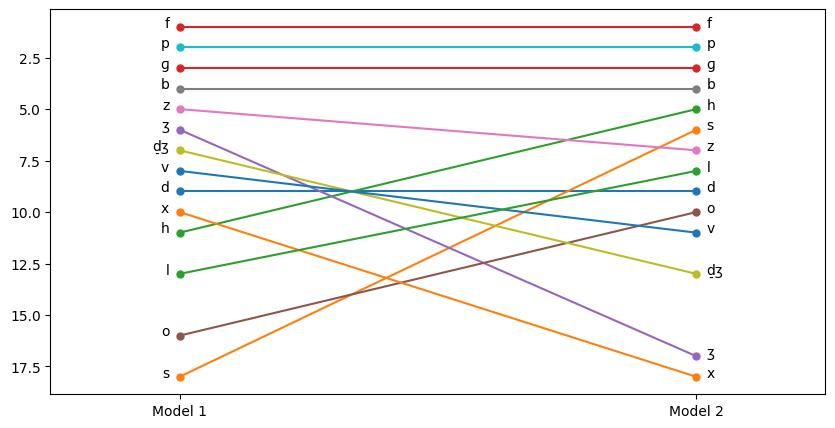

In [34]:
plt.figure(figsize=(10,5))
plt.gca().invert_yaxis()
for segment in segments_for_analysis:
    tmp = both_models.loc[both_models.Segment == segment]
    plt.plot(tmp.Model, tmp.Rank, marker='o', markersize=5)
    # end label
    plt.text(1.02, tmp.Rank.values[1], segment)
    # start label
    plt.text(-0.02, tmp.Rank.values[0], segment, ha='right')
_ = plt.xticks([0, 1], ['Model 1', 'Model 2'])
plt.xlim(-0.25, 1.25)
plt.show()